In [1]:
#https://kwkelly.com/blog/analyzing-capital-bikeshare-data-with-python-and-pandas/
import pandas as pd
import xml.etree.ElementTree as et
import re
import urllib.request
from urllib.request import urlopen
import shutil
import zipfile
from collections import defaultdict
import csv
import sys
from ast import literal_eval
import os
from datetime import timedelta
import plotly
from math import sin, cos, sqrt, atan2, radians
from IPython.display import Image

PATH = '/Users/apseyed/Dropbox/enpm808w-materials/enpm-808-content-organization/data/'

def get_station_xml():
    url = "https://www.capitalbikeshare.com/data/stations/bikeStations.xml"
    if not os.path.exists(PATH):
        os.mkdir(download_dir)
    file_name = os.path.join(PATH, 'bikeStations.xml')
    response = urlopen(url)
    outfile = open(file_name, 'wb')
    shutil.copyfileobj(response, outfile)
    
def xml_to_pandas(xml_file):
    tree = et.parse(xml_file)
    root = tree.getroot()
    l = []
    for station in root:
        d = {}
        for attrib in station:
            d[str(attrib.tag)] = str(attrib.text)
            #print("    " + str(attrib.tag) + " : " + str(attrib.text))
        l.append(d)
    df = pd.DataFrame.from_dict(l)
    return df

def parse_stations(station_str):
    station_regex = re.compile(r'\((?P<code>\d+?)\)')
    try:
        station_code = int(station_regex.search(station_str).group('code'))
    except ValueError:
        station_code = None
    except TypeError:
        station_code = None
    return station_code

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
PATH = 'MyDrive/enpm808w-datasets/bikeshare/'


Mounted at /content/drive


In [3]:
#get and show "normalized" bike station data

pd.set_option('display.expand_frame_repr', False)
#get_station_xml()
#bike_stations = xml_to_pandas(PATH + 'bikeStations.xml')
bike_stations = xml_to_pandas(PATH + 'bikeStations.xml')

print ("\nbike stations:\n")
print (bike_stations.head(4))
print ("\n")

FileNotFoundError: ignored

In [ ]:
#Merging usage and station data

pd.set_option('display.expand_frame_repr', False)
#get_station_xml()

data = pd.read_csv(PATH + '2011-Q1-Trips-History-Data.csv')
print ("trip history (before):\n")
print (data.head(4))

bike_stations = xml_to_pandas(PATH + 'bikeStations.xml')
print ("\nbike stations:\n")
print (bike_stations.head(4))
print ("\n")

data['Start station'] = data['Start station'].apply(parse_stations)
data['End station'] = data['End station'].apply(parse_stations)
data = data.dropna()
data['End station'] = data['End station'].astype(int)

print ("trip history (after):\n") 
print (data.head(4))

print("\nbike stations:")
print (bike_stations.head(4))

bike_stations['terminalName'] = bike_stations['terminalName'].astype(int)
bike_stations['lat'] = bike_stations['lat'].astype(float)
bike_stations['long'] = bike_stations['long'].astype(float)
station_locations = bike_stations[['terminalName']]


trip history (before):

           Duration       Start date         End date                                      Start station                                   End station   Bike# Member Type
0   0h 1min. 50sec.  3/31/2011 23:58    4/1/2011 0:00                       14th & Harvard St NW (31105)                  16th & Harvard St NW (31103)  W00749  Registered
1  0h 16min. 21sec.  3/31/2011 23:52    4/1/2011 0:08                             19th & L St NW (31224)     7th & Water St SW / SW Waterfront (31609)  W01048      Casual
2   0h 3min. 19sec.  3/31/2011 23:47  3/31/2011 23:50  Lincoln Park / 13th & East Capitol St NE  (31619)                        13th & H St NE (31611)  W00340  Registered
3   0h 5min. 44sec.  3/31/2011 23:45  3/31/2011 23:50                             14th & R St NW (31202)  Massachusetts Ave & Dupont Circle NW (31200)  W00981  Registered

bike stations:

    id                              name terminalName lastCommWithServer         lat        long install

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
print("\nstation locations:")

print(station_locations.head(4))

#station_locations['location'] = bike_stations['lat'].map(str)  + ":" + bike_stations['long'].map(str) 
station_locations['location'] = list(zip(bike_stations['lat'], bike_stations['long']))
print(station_locations.head(4))

data = data.merge(station_locations, how='left', left_on='Start station', right_on='terminalName')
data.columns = [w if w != 'location' else 'startPos' for w in data.columns]
data.drop('terminalName', axis=1, inplace=True)

data = data.merge(station_locations, left_on='End station', right_on='terminalName')
data.columns = [w if w != 'location' else 'endPos' for w in data.columns]
data.drop('terminalName', axis=1, inplace=True)

print ("\ntrip history (after merge):\n")
print (data.head(4))


station locations:
   terminalName
0         31212
1         31215
2         31227
3         31233
   terminalName                  location
0         31212    (38.90534, -77.046774)
1         31215  (38.9022212, -77.059219)
2         31227   (38.900283, -77.029822)
3         31233   (38.902061, -77.038322)

trip history (after merge):

          Duration       Start date         End date  Start station  End station   Bike# Member Type                 startPos                   endPos
0  0h 1min. 50sec.  3/31/2011 23:58    4/1/2011 0:00          31105        31103  W00749  Registered      (38.9268, -77.0322)  (38.926088, -77.036536)
1  0h 6min. 28sec.  3/31/2011 23:11  3/31/2011 23:18          31229        31103  W00270  Registered    (38.91554, -77.03818)  (38.926088, -77.036536)
2  0h 7min. 57sec.  3/31/2011 22:25  3/31/2011 22:33          31400        31103  W00846  Registered  (38.936043, -77.024649)  (38.926088, -77.036536)
3  0h 6min. 36sec.  3/31/2011 22:15  3/31/2011 22:22    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
from datetime import datetime

def timeDistance(row,FMT="%m/%d/%Y %H:%M"):
    td = datetime.strptime(row['End date'], FMT) - datetime.strptime(row['Start date'], FMT)
    days = td.days
    hours, remainder = divmod(td.seconds, 3600)
    #print ("%s, %s, %s" % (row['Start date'], row['End date'], hours ))
    return hours

def dayHour(time,FMT='%m/%d/%Y %H:%M'):
    d = datetime.strptime(time, FMT)
    t = d.hour + (d.minute / 60.0)
    return t

def parse_time(time_str):
    time_regex = re.compile(r'((?P<hours>\d+?)h )?((?P<minutes>\d+?)min. )?((?P<seconds>\d+?)sec.)?')
    parts = time_regex.match(time_str)
    if not parts:
        return
    parts = parts.groupdict()
    time_params = {}
    for (name, param) in parts.items():
        if param:
            time_params[name] = int(param)
    return timedelta(**time_params)

In [ ]:
#testing timeDistance and dayHour

s1 = '4/1/2011 0:00'
s2 = '3/31/2011 17:19' # for example
FMT = "%m/%d/%Y %H:%M"
dict = {'Start date' : '4/5/2011 2:00', 'End date' : '4/5/2011 6:19' }
print (timeDistance(dict,FMT))
print (dayHour(s2,FMT))

#a = '3/30/2011 11:47'
#b = '3/31/2011 11:58'
#dict = {'Start date' : a, 'End date' : b }
#print timeDistance(dict,FMT)
#dict = {'End date' : a, 'Start date' : b }
#print timeDistance(dict,FMT)


a='3/31/2011 23:47'  
b='3/31/2011 23:50'
dict = {'End date' : b, 'Start date' : a }
timeDistance(dict,FMT)

a='3/31/2011 23:58'    
b='4/1/2011 1:00'
dict = {'End date' : b, 'Start date' : a }
timeDistance(dict,FMT)


4
17.316666666666666


1

In [ ]:
data['StartHour'] = data['Start date'].apply(dayHour)
#data['duration'] = data.apply(lambda row: timeDistance(row['Start date'], row['End date']), axis=1)
data['duration'] = data.apply(timeDistance, axis=1)
#data['Duration'] = data['Duration'].apply(parse_time)

print (data.head(5))

#the R we are simulating here
#rides$duration <- apply(rides, 1, function(row) timeDistance(row['Start.date'], row['End.date']))
from geopy.distance import distance
try:
    data['distance'] = data.apply(lambda row: distance(row['startPos'], row['endPos']).miles, axis=1)
except ValueError:
    print("valuerror")
print (data.head(5))

data.to_csv(PATH + 'normalized-bike-data.csv')

          Duration       Start date         End date  Start station  End station   Bike# Member Type                 startPos                   endPos  StartHour  duration
0  0h 1min. 50sec.  3/31/2011 23:58    4/1/2011 0:00          31105        31103  W00749  Registered      (38.9268, -77.0322)  (38.926088, -77.036536)  23.966667         0
1  0h 6min. 28sec.  3/31/2011 23:11  3/31/2011 23:18          31229        31103  W00270  Registered    (38.91554, -77.03818)  (38.926088, -77.036536)  23.183333         0
2  0h 7min. 57sec.  3/31/2011 22:25  3/31/2011 22:33          31400        31103  W00846  Registered  (38.936043, -77.024649)  (38.926088, -77.036536)  22.416667         0
3  0h 6min. 36sec.  3/31/2011 22:15  3/31/2011 22:22          31106        31103  W00472  Registered  (38.923203, -77.047637)  (38.926088, -77.036536)  22.250000         0
4  0h 5min. 30sec.  3/31/2011 20:19  3/31/2011 20:24          31602        31103  W01105  Registered      (38.9308, -77.0315)  (38.926088, -

/usr/local/lib/python3.7/dist-packages/geopy/point.py:180: UserWarning: A single number has been passed to the Point constructor. This is probably a mistake, because constructing a Point with just a latitude seems senseless. If this is exactly what was meant, then pass the zero longitude explicitly to get rid of this warning.
  UserWarning)


valuerror
          Duration       Start date         End date  Start station  End station   Bike# Member Type                 startPos                   endPos  StartHour  duration
0  0h 1min. 50sec.  3/31/2011 23:58    4/1/2011 0:00          31105        31103  W00749  Registered      (38.9268, -77.0322)  (38.926088, -77.036536)  23.966667         0
1  0h 6min. 28sec.  3/31/2011 23:11  3/31/2011 23:18          31229        31103  W00270  Registered    (38.91554, -77.03818)  (38.926088, -77.036536)  23.183333         0
2  0h 7min. 57sec.  3/31/2011 22:25  3/31/2011 22:33          31400        31103  W00846  Registered  (38.936043, -77.024649)  (38.926088, -77.036536)  22.416667         0
3  0h 6min. 36sec.  3/31/2011 22:15  3/31/2011 22:22          31106        31103  W00472  Registered  (38.923203, -77.047637)  (38.926088, -77.036536)  22.250000         0
4  0h 5min. 30sec.  3/31/2011 20:19  3/31/2011 20:24          31602        31103  W01105  Registered      (38.9308, -77.0315)  (38

In [ ]:
data['duration'].value_counts()

0     144041
1       3829
2       1186
3        373
4        112
5         51
6         33
7         14
9         13
19        12
13        10
10         9
18         9
8          8
15         7
11         7
14         7
23         7
16         6
12         6
22         5
17         3
21         3
20         2
Name: duration, dtype: int64

In [ ]:
def timeName(start):
    """
    Convert 24-hour times into a human-readable format
    """
    while start > 24:
        start -= 24
    if start < 3:
        return "LATENIGHT"
    elif start < 7:
        return "EARLYMORN"
    elif start < 11:
        return "LATEMORN"
    elif start < 15:
        return "AFTERNOON"
    elif start < 19:
        return "EVENING"
    elif start < 23:
        return "NIGHT"
    else:
        return "LATENIGHT"

def coords(loc):
    """
    Turn string into a usable format
    """
    loc = literal_eval(loc)
    return (float(loc[0]), float(loc[1]))

In [ ]:
input_filename = 'normalized-bike-data.csv'
infile = csv.DictReader(open(PATH + input_filename, 'r'))
starts  = defaultdict(lambda: defaultdict())
ends  = defaultdict(lambda: defaultdict())
locs = { } 

# Go through all the lines in the normalized file, group by the count
for row in infile:
    startStation = row["Start station"]
    endStation = row["End station"]
    try:
        startTimeName = timeName(float(row["StartHour"]))
    except ValueError:
        startTimeName = None
    try:
        endTimeName = timeName(float(row["StartHour"]) + float(row["duration"]))
    except ValueError:
        endTimeName = None
    
    #print("start: %s, end %s: " % (row["startPos"], row["endPos"] ))
    #if not startStation in locs:
    #    locs[startStation] = coords(row["startPos"])
    
    # some error handling
    if row["startPos"] == None or row['startPos'] == '':
        continue
    
    if not startStation in locs:
        locs[startStation] = coords(row["startPos"])
    if not endStation in locs:
        locs[endStation] = coords(row["endPos"])

        
    startCount = 0
    endCount = 0  
    if startStation in starts:
        if starts[startStation].get(startTimeName) is not None:
            startCount = starts[startStation].get(startTimeName)    
    if endStation in ends:
        if ends[endStation].get(endTimeName) is not None:
            endCount = ends[endStation].get(endTimeName)
    if startTimeName:
        starts[startStation][startTimeName] = startCount + 1
    if endTimeName:
        ends[endStation][endTimeName] = endCount + 1
    

In [ ]:
header = ["station", "type", "count", "time", "lat", "long"]
afile = open(PATH + 'cabi-station-counts2.csv', 'w')
outfile = csv.DictWriter(afile, fieldnames=header)
outfile.writeheader()
#outfile.writerow([(x,x) for x in header])

for type in ["Leave", "Return"]:
    stations = starts
    if type == "Return":
        stations = ends

    for row in stations:
        d = {}
        d["station"] = row
        d["type"] = type
        d["lat"], d["long"] = locs[row]
        #print(d)

        for tt in stations[row]:
            d["time"] = tt
            d["count"] = stations[row][tt]
            #print(d)

            outfile.writerow(d)
afile.close()

In [ ]:
print(d)

{'station': '31704', 'type': 'Return', 'lat': 38.901385, 'long': -76.941877, 'time': 'EVENING', 'count': 1}


In [ ]:
!ls -l $PATH

total 120897
-rw------- 1 root root 19689201 Aug 22 13:56 2011-Q1-Trips-History-Data.csv
-rw------- 1 root root   226513 Aug 22 13:56 bikeStations-revised.xml
-rw------- 1 root root   226512 Aug 22 13:56 bike_stations.xml
-rw------- 1 root root   255177 Aug 22 13:56 bikeStations.xml
-rw------- 1 root root 26879336 Aug 22 13:56 cabi-nz-rides.ext.csv
-rw------- 1 root root 28149502 Aug 22 13:56 cabi-rides.ext.csv
-rw------- 1 root root  1495499 Aug 22 13:56 cabi-rides.ext.csv.old
-rw------- 1 root root  1155857 Aug 22 13:56 cabi-sample-rides.filtered.csv
-rw------- 1 root root    56654 Sep 13 18:28 cabi-station-counts2.csv
-rw------- 1 root root    56853 Aug 22 13:56 cabi-station-counts2.csv.bkup
-rw------- 1 root root    94427 Aug 22 13:56 cabi-station-counts.csv
-rw------- 1 root root 22733104 Sep 13 18:28 normalized-bike-data.csv
-rw------- 1 root root 22771877 Aug 22 13:56 normalized-bike-data.csv.test
drwx------ 2 root root     4096 Sep  5 20:39 Wards_from_2012


In [ ]:
dfCounts = pd.read_csv(PATH + 'cabi-station-counts2.csv')

In [ ]:
dfCounts.head()

,station,type,count,time,lat,long
0,31105,Leave,134,LATENIGHT,38.9268,-77.0322
1,31105,Leave,509,NIGHT,38.9268,-77.0322
2,31105,Leave,497,EVENING,38.9268,-77.0322
3,31105,Leave,520,AFTERNOON,38.9268,-77.0322
4,31105,Leave,933,LATEMORN,38.9268,-77.0322


In [ ]:
!pip install geopandas
!pip install ipyleaflet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 38.0 MB/s 
     |████████████████████████████████| 6.3 MB 40.9 MB/s 
     |████████████████████████████████| 16.7 MB 69.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.4 MB 35.6 MB/s 
     |████████████████████████████████| 1.6 MB 47.3 MB/s 


In [ ]:
import pickle
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import glob
import geopandas
from geopy import Nominatim
import numpy as np
from ipyleaflet import Map, Marker
from sklearn.utils import shuffle
from IPython.display import HTML
from IPython.display import Image
from IPython.core.display import HTML 
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
plt.style.use('bmh')

In [ ]:
!ls $PATH

2011-Q1-Trips-History-Data.csv	cabi-sample-rides.filtered.csv
bikeStations-revised.xml	cabi-station-counts2.csv
bike_stations.xml		cabi-station-counts2.csv.bkup
bikeStations.xml		cabi-station-counts.csv
cabi-nz-rides.ext.csv		normalized-bike-data.csv
cabi-rides.ext.csv		normalized-bike-data.csv.test
cabi-rides.ext.csv.old		Wards_from_2012


In [ ]:
gdf = geopandas.GeoDataFrame.from_file(os.path.join(PATH, "Wards_from_2012/Wards_from_2012.shx"))

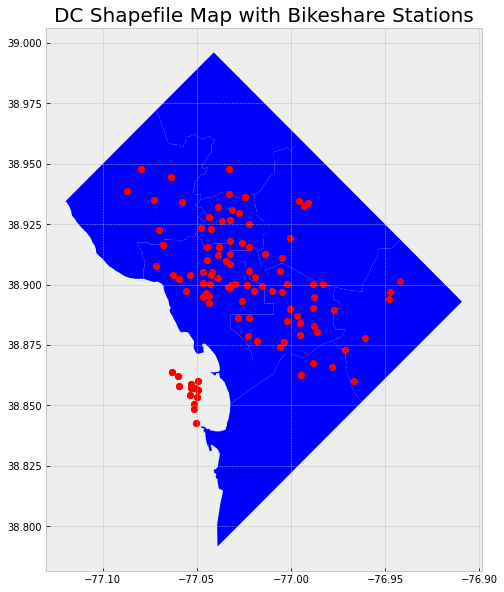

In [ ]:
gdf.plot(figsize=(10, 10))
plt.scatter(x=dfCounts['long'], y=dfCounts['lat'], alpha=.5, c='r')
plt.title('DC Shapefile Map with Bikeshare Stations', size=20)
plt.show()

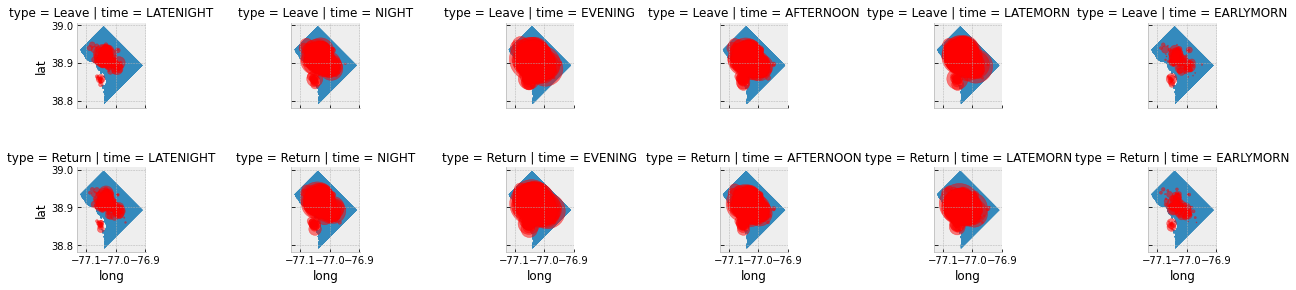

In [ ]:
grid = sns.FacetGrid(dfCounts, col='time', row='type')
for ax in grid.axes.flatten():
    grid.map(gdf.plot, ax=ax, figsize=(10, 10))
grid.map(plt.scatter, 'long', 'lat', 'count', alpha=.5, color='r')
#Contributed by Arunava Basu